# `BUILDING A REGRESSION MODEL TO FORECAST SALES` 
#### Using the CRISP-DM framework

## `Business Understanding`


#### Goal/Description
To create a machine learning model to forecast the demand of products in various locations.

#### `Null Hypothesis`
There is no relationship between the average sales and the average sales of the various branches

#### `Alternate Hypothesis`
There is a relationship between the average sales and the average sales of the various branches

### `Key Metrics and Success Criteria`

The success of this poject will be evaluated based on several key metrics and success criteria including;





#### `Analytical Questions`

- Is the train dataset complete (has all the required dates)?
- Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
- Compare the sales for each month across the years and determine which month of which year had the highest sales.
- Did the earthquake impact sales?
- Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
- Are sales affected by promotions, oil prices and holidays?
- What analysis can we get from the date and its extractable features?
- Which product family and stores did the promotions affect.
- What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
- Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

## `Data Understanding`

#### Data Source
The data was sourced from three places:
- Three tables from Corporation Favorita's database 
- Two csv files from a OneDrive location
- Two csv files from a GitHub repository 
 

#### Data Features

- store_nbr : Identifies the store at which the products are sold.

- family : identifies the type of product sold.

- sales : gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

- onpromotion : gives the total number of items in a product family that were being promoted at a store at a given date.

#### Data Exploration

##### `Libraries`

In [56]:
#Libraries imported
import sqlalchemy as sa
import pyodbc  
from dotenv import dotenv_values 
import pandas as pd
from scipy import stats 
import plotly.express as px
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')

##### `Database Connection`

In [57]:
#Access protocols for the SQL Database
env_variables = dotenv_values('logins.env')
database = env_variables.get('database')
server = env_variables.get('server')
username = env_variables.get('username')
password = env_variables.get('password')

Python-dotenv could not parse statement starting at line 5


In [58]:
#Creation of Connection to Database
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"
connection = pyodbc.connect(connection_string)

In [59]:
#Querying SQL Database and reading the table into a dataframe
query = "SELECT * FROM oil"

oil_df = pd.read_sql(query, connection,parse_dates= 'date')#,index_col=['date'])
oil_df.info
oil_df.head(5)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [60]:
#Querying SQL Database and reading the table into a dataframe
query = "SELECT * FROM holidays_events"

hdays_df = pd.read_sql(query, connection,parse_dates='date')
hdays_df.info
hdays_df.head(5)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [61]:
#Querying SQL Database and reading the table into a dataframe
query = "SELECT * FROM stores"

stores_df= pd.read_sql(query, connection,index_col='store_nbr')
stores_df.head(10)

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
6,Quito,Pichincha,D,13
7,Quito,Pichincha,D,8
8,Quito,Pichincha,D,8
9,Quito,Pichincha,B,6


In [62]:
##Accessing the csv data 
sales_df = pd.read_csv("data\\store-sales-forecasting\\train.csv",parse_dates = ['date'])
sales_df.tail(10)

,id,date,store_nbr,family,sales,onpromotion
3000878,3000878,2017-08-15,9,MAGAZINES,11.000,0
3000879,3000879,2017-08-15,9,MEATS,449.228,0
3000880,3000880,2017-08-15,9,PERSONAL CARE,522.000,11
3000881,3000881,2017-08-15,9,PET SUPPLIES,6.000,0
3000882,3000882,2017-08-15,9,PLAYERS AND ELECTRONICS,6.000,0
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [63]:
##Accessing the csv data 
transact_df = pd.read_csv("data\\store-sales-forecasting\\transactions.csv",parse_dates = ['date'])
transact_df.head(10)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
5,2013-01-02,5,1903
6,2013-01-02,6,2143
7,2013-01-02,7,1874
8,2013-01-02,8,3250
9,2013-01-02,9,2940


In [64]:
## Call the train dataframe

train_df=pd.read_csv('data\\store-sales-forecasting\\train.csv',parse_dates = ['date'])
train_df.info

<bound method DataFrame.info of               id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

       

### DATA UNDERSTANDING

In [65]:
#Checking for missing values
train_df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

### EDA

In [66]:
### finding missing days in the sales data
train_df.isnull().sum()

start_day = train_df.date.min()
end_day = train_df.date.max()

print(f'Start Date: {start_day} \n\n End Date : {end_day}')

existing_date = pd.date_range(start=start_day,end = end_day,freq="D")

missing_dates_train = existing_date[~existing_date.isin(train_df.index)]
print(f'The missing dates are : \n\n {missing_dates_train}')

Start Date: 2013-01-01 00:00:00 

 End Date : 2017-08-15 00:00:00
The missing dates are : 

 DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', length=1688, freq='D')


In [67]:
# Function to get the day name from a date string
from dateutil.parser import parse

def get_day_name(date_str):
    return date_str.strftime('%A')


day_names = []
# Get day names for each specific date
for date in missing_dates_train:
    day = get_day_name(date)
    day_names.append(day)


# print("Day names for specific dates:")
# for date, day_name in zip(missing_dates_train, day_names):
#     print(f"{date}: {day_name}")

# Create a DataFrame for missing dates
missing_dates_df = pd.DataFrame({'date': pd.to_datetime(missing_dates_train)})
missing_dates_df.shape
    

(1688, 1)

In [68]:
from itertools import product
missing_dates_train = existing_date[~existing_date.isin(train_df.index)]
store_nbrs = train_df.store_nbr.unique()
family = train_df.family.unique()

missing_products = list(product(store_nbrs,family,missing_dates_train))

In [69]:
missing_df = pd.DataFrame(missing_products, columns=['store_nbr','family', 'date'])

In [70]:
missing_df

,store_nbr,family,date
0,1,AUTOMOTIVE,2013-01-01
1,1,AUTOMOTIVE,2013-01-02
2,1,AUTOMOTIVE,2013-01-03
3,1,AUTOMOTIVE,2013-01-04
4,1,AUTOMOTIVE,2013-01-05
...,...,...,...
3008011,9,SEAFOOD,2017-08-11
3008012,9,SEAFOOD,2017-08-12
3008013,9,SEAFOOD,2017-08-13
3008014,9,SEAFOOD,2017-08-14


In [71]:
# function to create the year,month and days
def calender(df): 

    df['monthname'] = df['date'].dt.month_name()
    df['dayname'] = df['date'].dt.day_name()
    df['day']= df['date'].dt.day
    df['year'] = df['date'].dt.year

    return df

In [72]:
missing_df1= calender(missing_df)

missing_df1

,store_nbr,family,date,monthname,dayname,day,year
0,1,AUTOMOTIVE,2013-01-01,January,Tuesday,1,2013
1,1,AUTOMOTIVE,2013-01-02,January,Wednesday,2,2013
2,1,AUTOMOTIVE,2013-01-03,January,Thursday,3,2013
3,1,AUTOMOTIVE,2013-01-04,January,Friday,4,2013
4,1,AUTOMOTIVE,2013-01-05,January,Saturday,5,2013
...,...,...,...,...,...,...,...
3008011,9,SEAFOOD,2017-08-11,August,Friday,11,2017
3008012,9,SEAFOOD,2017-08-12,August,Saturday,12,2017
3008013,9,SEAFOOD,2017-08-13,August,Sunday,13,2017
3008014,9,SEAFOOD,2017-08-14,August,Monday,14,2017


In [73]:
### Adding the missing dates to the dataframe
# Merge with specific dates to include missing dates
train_df = train_df.reset_index(drop=False)
train_df = pd.concat([train_df, missing_df], ignore_index=True)


In [74]:
### Merging the sales and oil dataframes
combined_df = pd.merge(sales_df, oil_df , on='date', how='left') 
                       

In [75]:
### Merging the sales ,stores and oil dataframes
combined_df = pd.merge(combined_df, stores_df, on='store_nbr', how='left')
combined_df.head(5)

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13


In [76]:
### Merging the sales,holidays and oil dataframes
combined_hso_df = pd.merge(combined_df, hdays_df , on='date', how='left') 
combined_hso_df.head(10)

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
6,6,2013-01-01,1,CELEBRATION,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
7,7,2013-01-01,1,CLEANING,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
8,8,2013-01-01,1,DAIRY,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
9,9,2013-01-01,1,DELI,0.0,0,NaN,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False


In [77]:
### finding missing days in the sales data
transact_df.isnull().sum()

start_day = transact_df.index.min()
end_day = transact_df.index.max()

print(f'{start_day} \n\n {end_day}')

existing_date = pd.date_range(start=start_day,end = end_day,freq="D")

missing_dates = existing_date[~existing_date.isin(transact_df.index)]
print(missing_dates)

0 

 83487
DatetimeIndex(['1970-01-01'], dtype='datetime64[ns]', freq='D')


In [78]:
#Checking for missing values
combined_hso_df.isnull().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
dcoilwtico      955152
city                 0
state                0
type_x               0
cluster              0
type_y         2551824
locale         2551824
locale_name    2551824
description    2551824
transferred    2551824
dtype: int64

In [79]:
combined_eda= combined_hso_df.copy()

combined_eda.dropna()

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
73062,73062,2013-02-11,1,AUTOMOTIVE,0.000,0,97.010002,Quito,Pichincha,D,13,Holiday,National,Ecuador,Carnaval,False
73063,73063,2013-02-11,1,BABY CARE,0.000,0,97.010002,Quito,Pichincha,D,13,Holiday,National,Ecuador,Carnaval,False
73064,73064,2013-02-11,1,BEAUTY,0.000,0,97.010002,Quito,Pichincha,D,13,Holiday,National,Ecuador,Carnaval,False
73065,73065,2013-02-11,1,BEVERAGES,172.000,0,97.010002,Quito,Pichincha,D,13,Holiday,National,Ecuador,Carnaval,False
73066,73066,2013-02-11,1,BOOKS,0.000,0,97.010002,Quito,Pichincha,D,13,Holiday,National,Ecuador,Carnaval,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,47.570000,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.570000,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.570000,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.570000,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [80]:
combined_hso_df['dcoilwtico'] = combined_hso_df['dcoilwtico'].bfill()
combined_hso_df['onpromotion'] = combined_hso_df['onpromotion'].fillna(0)
combined_hso_df['transferred'] = combined_hso_df['transferred'].fillna(False)
combined_hso_df['description'] = combined_hso_df['description'].fillna('None')
combined_hso_df['locale'] = combined_hso_df['locale'].fillna('None')
combined_hso_df['locale_name'] = combined_hso_df['locale_name'].fillna('None')
combined_hso_df['type_y'] = combined_hso_df['type_y'].fillna('None')
combined_hso_df['type_x'] = combined_hso_df['type_x'].fillna('None')
combined_hso_df['sales'] = combined_hso_df['sales'].fillna(0)
combined_hso_df['store_nbr'] = combined_hso_df['store_nbr'].fillna(0)
combined_hso_df['family'] = combined_hso_df['family'].fillna('None')
combined_hso_df['city'] = combined_hso_df['city'].fillna('None')
combined_hso_df['state'] = combined_hso_df['state'].fillna('None')
combined_hso_df['cluster'] = combined_hso_df['cluster'].fillna(0)

In [81]:
#Checking for missing values
combined_hso_df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dcoilwtico     0
city           0
state          0
type_x         0
cluster        0
type_y         0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [82]:
# function to create the year,month and days
def calender(df): 

    df['monthname'] = df['date'].dt.month_name()
    df['dayname'] = df['date'].dt.day_name()
    df['day']= df['date'].dt.day
    df['year'] = df['date'].dt.year

    return df

In [83]:
train_df = calender (train_df)
#combined_hso_df = calender (combined_hso_df)
#combined_eda = calender(combined_eda)

In [84]:
combined_hso_df

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.139999,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.000,0,93.139999,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.000,0,93.139999,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.000,0,93.139999,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.000,0,93.139999,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,47.570000,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.570000,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.570000,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.570000,Quito,Pichincha,B,6,Holiday,Local,Riobamba,Fundacion de Riobamba,False


In [85]:
combined_hso_df_2= combined_hso_df.set_index('date')
combined_eda = combined_eda.set_index('date')

#### Univariate Analysis

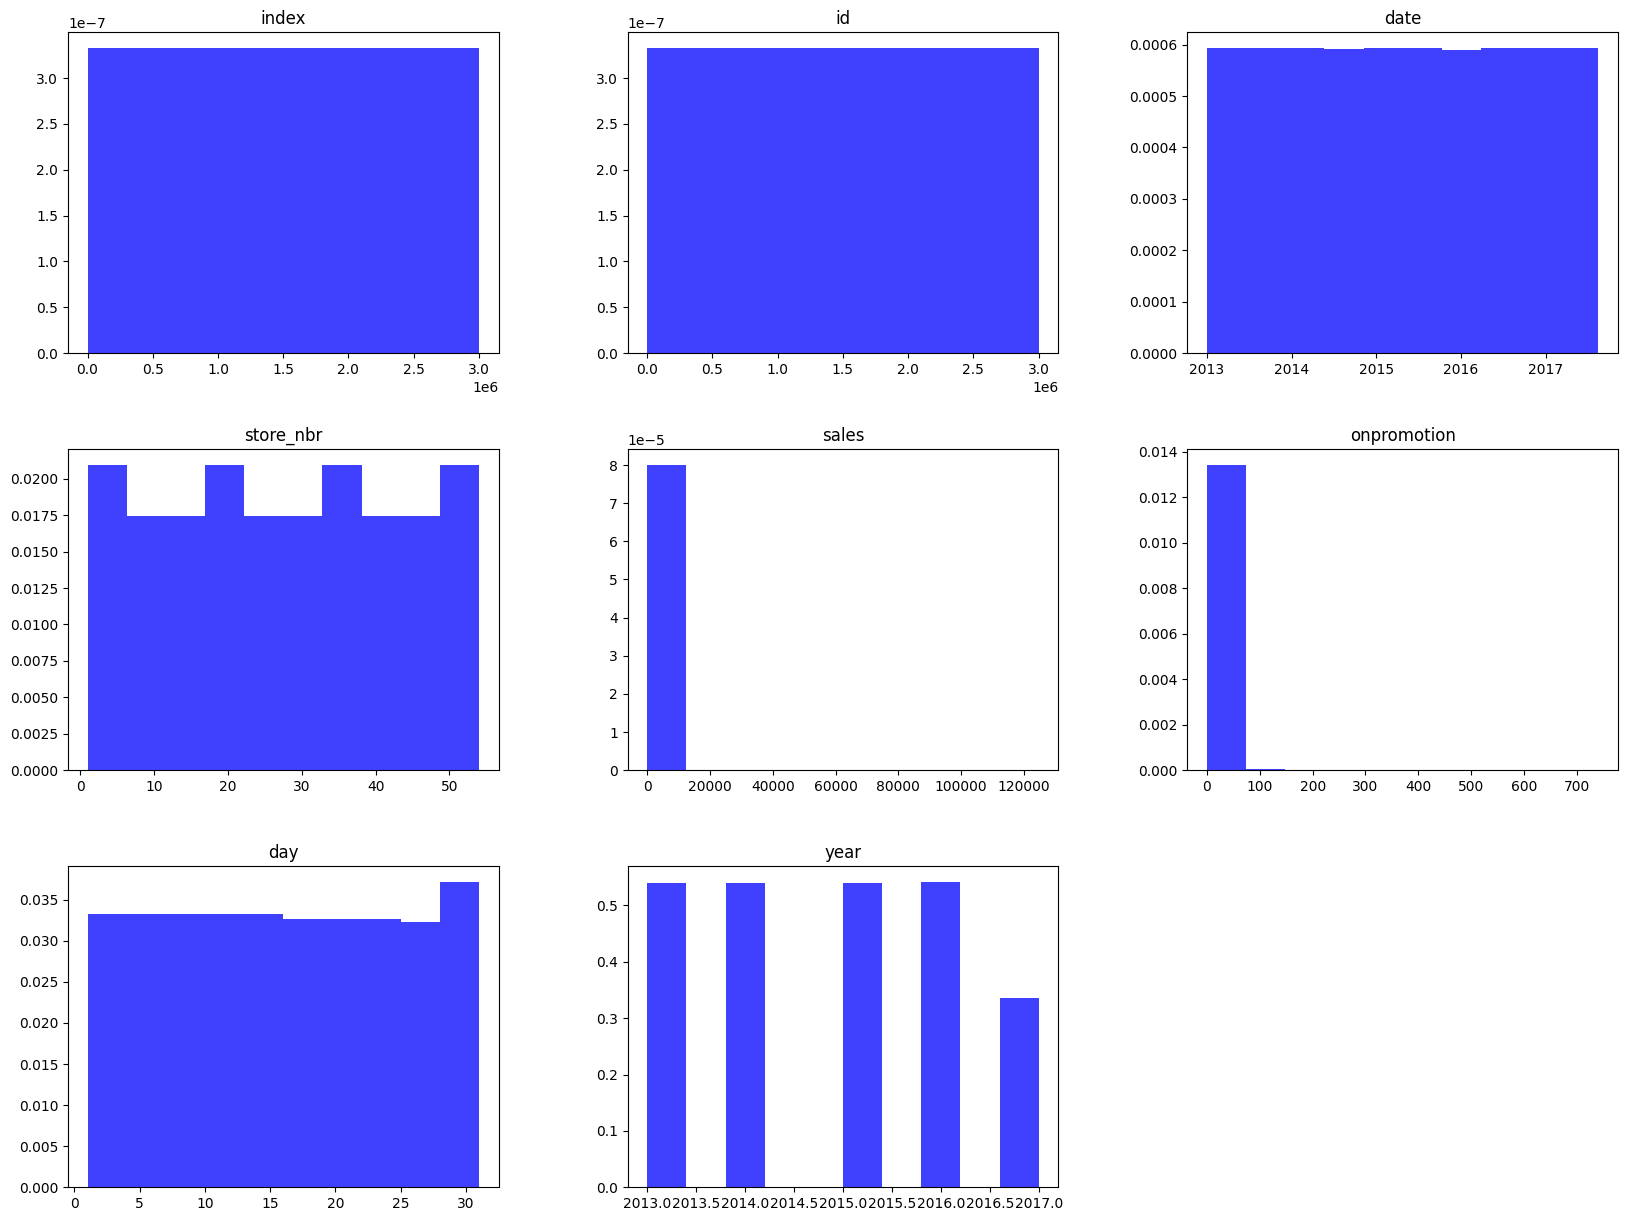

In [86]:
# Distribution of the variables
train_df.hist(density = True,figsize = (20, 15), facecolor = 'blue', alpha = 0.75,grid = False)

plt.show()

<Axes: xlabel='sales', ylabel='Density'>

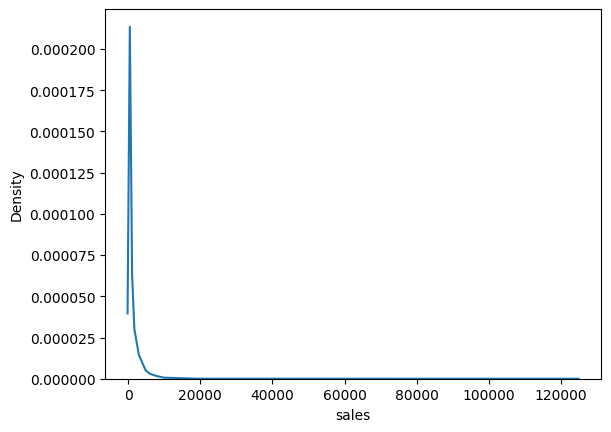

In [87]:
sns.kdeplot(train_df['sales'])

#### Observation
- Sales is left skewed

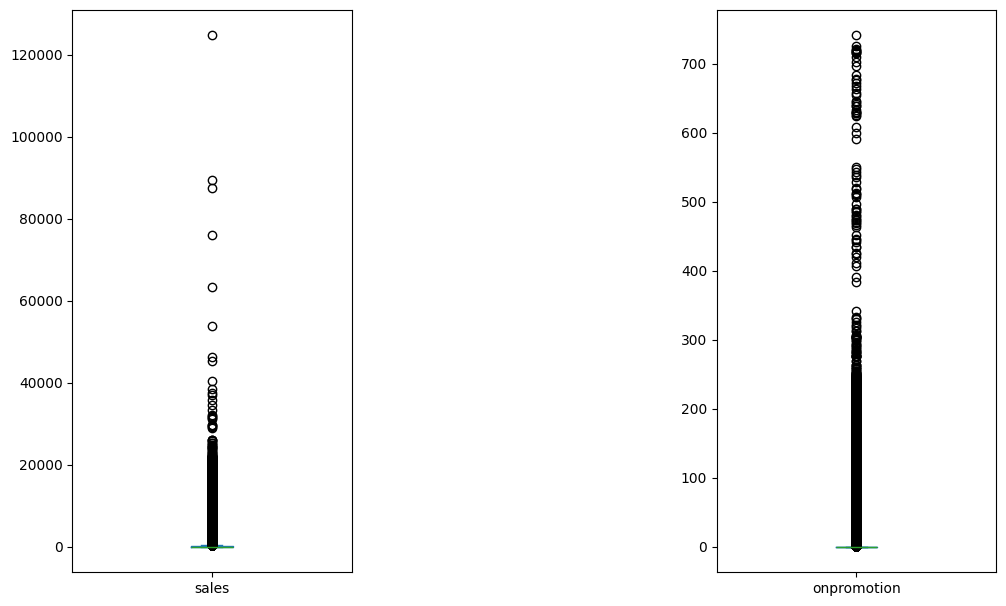

In [88]:
plt.subplot(131)
train_df['sales'].plot.box(figsize=(10,6))
plt.tight_layout(pad=0.5)
plt.subplot(133)
train_df['onpromotion'].plot.box()
plt.tight_layout(pad=0.5)

##### Observation

- A lot of outliers in sales and promotions

##### BiVariate Analysis

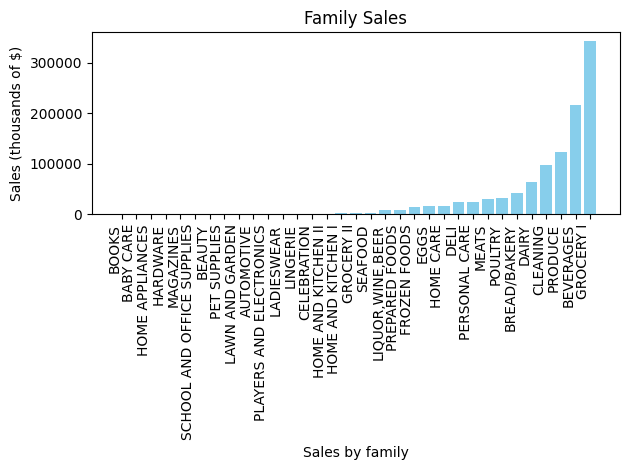

In [89]:
family_sales= (train_df.groupby('family')['sales'].sum()/1000).sort_values(ascending=True)
plt.bar(family_sales.index, family_sales, color='skyblue')
plt.xlabel('Sales by family')
plt.ylabel('Sales (thousands of $)')
plt.title('Family Sales')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


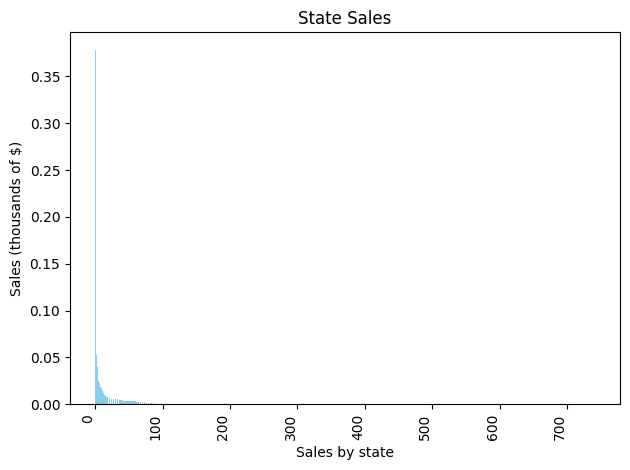

In [90]:
##### Find where there is no promotion

onpromotion_sales= (train_df.groupby('onpromotion')['sales'].sum()/1000000000)
plt.bar(onpromotion_sales.index, onpromotion_sales, color='skyblue')
plt.xlabel('Sales by state')
plt.ylabel('Sales (thousands of $)')
plt.title('State Sales')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

In [91]:
train_df

,index,id,date,store_nbr,family,sales,onpromotion,monthname,dayname,day,year
0,0.0,0.0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,January,Tuesday,1,2013
1,1.0,1.0,2013-01-01,1,BABY CARE,0.0,0.0,January,Tuesday,1,2013
2,2.0,2.0,2013-01-01,1,BEAUTY,0.0,0.0,January,Tuesday,1,2013
3,3.0,3.0,2013-01-01,1,BEVERAGES,0.0,0.0,January,Tuesday,1,2013
4,4.0,4.0,2013-01-01,1,BOOKS,0.0,0.0,January,Tuesday,1,2013
...,...,...,...,...,...,...,...,...,...,...,...
6008899,NaN,NaN,2017-08-11,9,SEAFOOD,NaN,NaN,August,Friday,11,2017
6008900,NaN,NaN,2017-08-12,9,SEAFOOD,NaN,NaN,August,Saturday,12,2017
6008901,NaN,NaN,2017-08-13,9,SEAFOOD,NaN,NaN,August,Sunday,13,2017
6008902,NaN,NaN,2017-08-14,9,SEAFOOD,NaN,NaN,August,Monday,14,2017


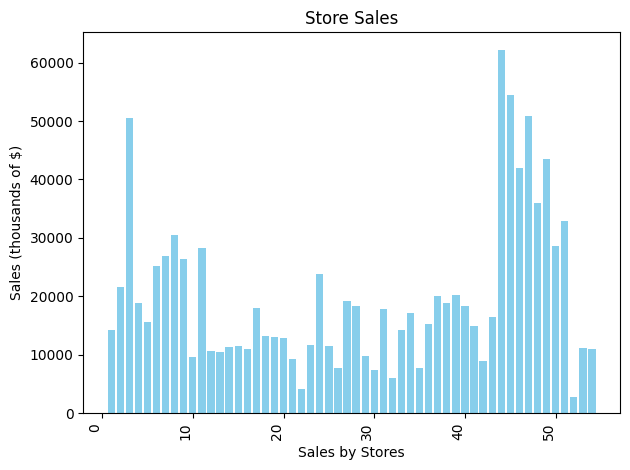

In [92]:
### Use plotly express here

store_sales= (train_df.groupby('store_nbr')['sales'].sum()/1000)
store_sales_sorted=store_sales.sort_values(ascending=False)
store_sales_sorted
plt.bar(store_sales_sorted.index, store_sales_sorted, color='skyblue')
plt.xlabel('Sales by Stores')
plt.ylabel('Sales (thousands of $)')
plt.title('Store Sales')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


#### Analytical Questions

#### Q1 Is the train dataset complete (has all the required dates)?


In [93]:
#missing dates in sales
missing_dates_df

### Merging the missing days with the holidays dataframe
combined_h_df = pd.merge(missing_dates_df, hdays_df , on='date', how='left') 


In [94]:
## The Dates with no data shows the missing days

###### Check for saturdays and sundays
combined_h_df.isnull().sum()

date              0
type           1432
locale         1432
locale_name    1432
description    1432
transferred    1432
dtype: int64

##### Observation

- Train Dataset is not complete, it has 1432 missing days


##### Q2 Which dates have the lowest and highest sales for each year (excluding days the store was closed)?


In [95]:
#Taking out all the zero values

non_zero_values = train_df[train_df.sales != 0].set_index('date')
unique_years= train_df.year.unique()
unique_years

data = pd.DataFrame(columns=['year', 'min_sales_date', 'max_sales_date'])

for d in unique_years:
    year= non_zero_values[non_zero_values.year == d]
    min_index = year.sales.idxmin()
    max_index= year.sales.idxmax()

    data.loc[len(data)] = d,min_index,max_index


data

,year,min_sales_date,max_sales_date
0,2013,2013-08-06,2013-11-12
1,2014,2014-12-05,2014-12-08
2,2015,2015-09-15,2015-12-14
3,2016,2016-06-23,2016-05-02
4,2017,2017-02-09,2017-04-02


#### Observation
From the data given : 
- From 2013-2015 ,the company had its maximum sales in the last quarter. 
- From 2016 - 2017 ,the company had its maximum sales mid-year

#### Q3 Compare the sales for each month across the years and determine which month of which year had the highest sales.


In [96]:
###resample or groupby
train_copy = train_df.set_index('date')
train_copy.sales.fillna(0,inplace = True)
train_copy.onpromotion.fillna(0,inplace = True)
# Downsample to monthly data by taking the mean
monthly_data = train_copy.sales.resample('ME').sum()



fig = px.line(monthly_data, x=monthly_data.index, y='sales', title='Yearly Sales Trend')

# Show the plot
fig.show()

##### Observation
- December 2016 had the highest sales of $ 29.64 million

Did the earthquake impact sales?


#### Q5 Are certain stores or groups of stores selling more products? (Cluster, city, state, type)


In [97]:
### Merging the sales and oil dataframes
store_sales_df = pd.merge(train_df, stores_df , on='store_nbr', how='left') 

for a in ['cluster','state','city','type']:

    store_sales= (store_sales_df.groupby(a)['sales'].sum()/1000000)
    store_sales_sorted=store_sales.sort_values(ascending=True)
    fig = px.line(store_sales, x=store_sales.index, y='sales', title=f'Store Sales by {a}')

# Show the plot
    fig.show()


#### Q5 Are sales affected by promotions, oil prices and holidays?


In [98]:
### Merging the sales and oil dataframes
combined_df = pd.merge(train_df, hdays_df , on='date', how='left').set_index('date')

promotions_holiday_df = combined_df[(combined_df.onpromotion > 0) | (combined_df.type == 'Holiday')]
straight_day_df = combined_df[(combined_df.onpromotion == 0) & (combined_df.type != 'Holiday')]

#fig = px.line(promotions_holiday_df , x=promotions_holiday_df.index, y='sales', title='Yearly Sales Trend')
##fig = px.line(straight_day_df , x=straight_day_df.index, y='sales', title='Yearly Sales Trend')
# Show the plot
#fig.show()

#### plt 2 graphs on one area


#### Observation

- It can be clearly seen that sales are much higher on promotion days or holidays

In [99]:
##What analysis can we get from the date and its extractable features?


#### Q7 Which product family and stores did the promotions affect.


In [100]:
promotions_df = store_sales_df[store_sales_df.onpromotion != 0]
promotions_df.head(3)

,index,id,date,store_nbr,family,sales,onpromotion,monthname,dayname,day,year,city,state,type,cluster
810784,810784.0,810784.0,2014-04-01,9,CLEANING,1752.0,3.0,April,Tuesday,1,2014,Quito,Pichincha,B,6
810789,810789.0,810789.0,2014-04-01,9,GROCERY I,7685.0,5.0,April,Tuesday,1,2014,Quito,Pichincha,B,6
812571,812571.0,812571.0,2014-04-02,9,GROCERY I,6481.0,3.0,April,Wednesday,2,2014,Quito,Pichincha,B,6


In [101]:
promotions_stores = promotions_df.groupby(['year','monthname','city','state','store_nbr'])['onpromotion'].count().sort_values(ascending=False)

promotions_stores.head(50)

#### Graph


year  monthname  city           state                           store_nbr
2016  May        Manta          Manabi                          53           910
                 El Carmen      Manabi                          54           797
2017  May        Quito          Pichincha                       48           604
                 Manta          Manabi                          52           592
                 Quito          Pichincha                       45           588
                                                                47           585
2016  December   Quito          Pichincha                       45           584
2017  May        Quito          Pichincha                       49           579
2016  December   Quito          Pichincha                       47           578
2017  May        Quito          Pichincha                       46           578
                 Guayaquil      Guayas                          51           575
                 Quito          Pic

#### Observation

- It can be observed that most of the promotions were done in 2016-2017 which can speak to the highest sales deviating from the usual Christmas period to May
- Store number 53 in Manta,Manabi had the overall highest number of promotions which occured in May,2016 
- Store number 54 in El Carmen in the same state as store number 53 followed closely with 797 promotions.


In [102]:
promotions_family = promotions_df.groupby(['year','monthname','city','family'])['onpromotion'].count().sort_values(ascending=False)
promotions_family.head(50)

### Graph

year  monthname  city   family       
2017  July       Quito  BEVERAGES        558
      March      Quito  BEVERAGES        558
      July       Quito  HOME CARE        558
      March      Quito  PERSONAL CARE    558
      May        Quito  DAIRY            558
      July       Quito  GROCERY I        558
      March      Quito  HOME CARE        558
                        GROCERY I        558
      July       Quito  PRODUCE          558
      March      Quito  CLEANING         558
                        DAIRY            558
      May        Quito  PERSONAL CARE    558
                        BEVERAGES        558
                        HOME CARE        558
      July       Quito  CLEANING         558
      May        Quito  BREAD/BAKERY     558
      July       Quito  DAIRY            558
      May        Quito  GROCERY I        558
                        CLEANING         558
      July       Quito  PERSONAL CARE    558
2016  May        Quito  BEVERAGES        557
                 

#### Observation

- A whole range of pdts /................................
- Be...............................1705 promotions 


In [103]:
#non_zero_values = combined_hso_df_2[combined_hso_df_2.sales != 0]

In [104]:
#What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)


#### Q9 Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

In [105]:
salary_days_df = store_sales_df[(store_sales_df.day == 15) | (store_sales_df.day > 25)]
normal_days_df = store_sales_df[(store_sales_df.day != 15) & (store_sales_df.day < 25)]

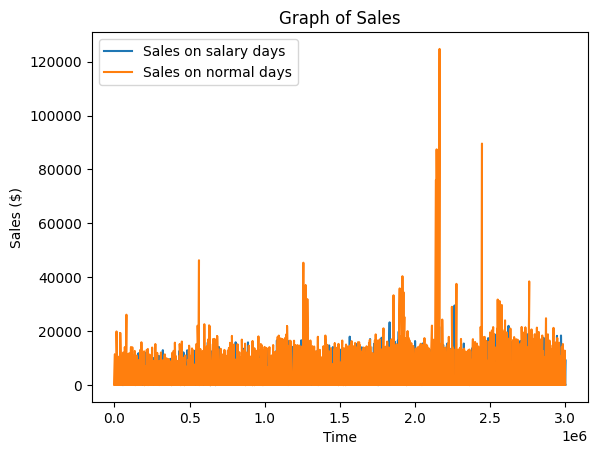

In [106]:
# Plotting
plt.plot(salary_days_df.index, salary_days_df.sales, label='Sales on salary days')
plt.plot(normal_days_df.index, normal_days_df.sales, label='Sales on normal days')

# Customize the plot (optional)
plt.xlabel('Time')
plt.ylabel('Sales ($)')
plt.title('Graph of Sales')
plt.legend()

# Show the plot
plt.show()

##### Observation
- Sales clearly doesnt depend on salary days

In [107]:
import matplotlib as mpl



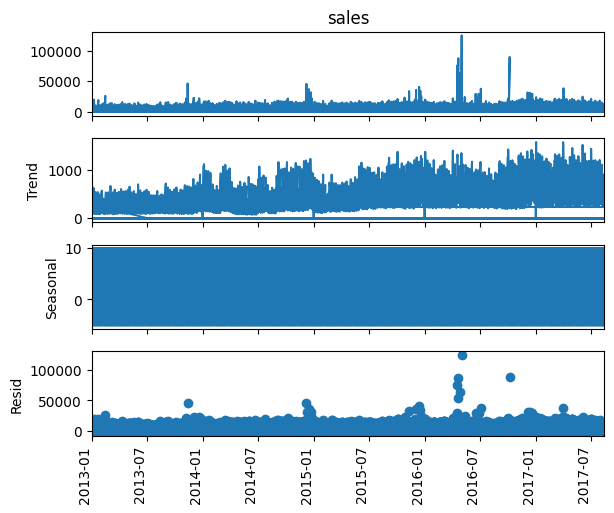

In [108]:
# Seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
##Overflow Issue resolution
import matplotlib.style as mplstyle
mplstyle.use('fast')
#ts = train_copy.set_index('date')['sales'] 
result = seasonal_decompose(train_copy.sales, model='additive', period=365,extrapolate_trend= 'freq')

result.plot()
plt.xticks(rotation=90, ha='right')
plt.show()

#### Observation
- There is a trend in the train data
- There are residuals present in the train data

In [110]:
train_copy.sales

date
2013-01-01    0.0
2013-01-01    0.0
2013-01-01    0.0
2013-01-01    0.0
2013-01-01    0.0
             ... 
2017-08-11    0.0
2017-08-12    0.0
2017-08-13    0.0
2017-08-14    0.0
2017-08-15    0.0
Name: sales, Length: 6008904, dtype: float64

In [111]:
### Test for stationarity using AD Fuller Test

from statsmodels.tsa.stattools import adfuller
 

# extracting only the passengers count using values function
\

# ADF Test
result = adfuller(train_copy.sales)
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


MemoryError: Unable to allocate 8.46 GiB for an array with shape (6009091, 189) and data type float64

In [ ]:
## Autocorrelation

In [ ]:
### Hypothesis

### Time series analysis is a method used for analysing time series data in order to extract meaningful statistical information from the data. Time series forecasting however, is all about predicting future values based on previously observed values over time.

##### 10 time series forecasting algorithm
Autoregressive (AR)
- Autoregressive Integrated Moving Average (ARIMA)
- Seasonal Autoregressive Integrated Moving Average (SARIMA)
- Exponential Smoothing (ES)
- XGBoost
- Prophet
- LSTM (Deep Learning)
- DeepAR
- N-BEATS
- Temporal Fusion Transformer (Google)

#### Building Statistical models for time series data

In [ ]:
AR,Sarima,arima,